In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found


In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import cv2

import tensorflow as tf
os.getcwd()

Using TensorFlow backend.


'/kaggle/working'

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
data_directory = '/kaggle/input/data/'
image_size = 256
batch_size = 32
os.chdir(data_directory)

In [5]:
df = pd.read_csv('Data_Entry_2017.csv')
os.chdir('/kaggle/working')

In [6]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(data_directory, 'images*', '*', '*.png'))}
df['path'] = df['Image Index'].map(data_image_paths.get)
df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_001/images/00000001_...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/kaggle/input/data/images_001/images/00000002_...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000003_...


In [7]:
labels=['Normal','Abnormal']
df['Normal']=list(map((lambda x: 1.0 if x=='No Finding' else 0.0),list(df['Finding Labels'])))
df['Abnormal']=list(map((lambda x: 0.0 if x=='No Finding' else 1.0),list(df['Finding Labels'])))

In [8]:
# generating labels for binary classificatiion
l=[]
for i in list(df['Finding Labels']):
    if i=='No Finding':
        l.append('Normal')
    else:
        l.append('Abnormal')
df['labels']=l

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=2018, stratify=df['labels'].map(lambda x: x[:4]))

In [10]:
core_idg = ImageDataGenerator(rescale=1 / 255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.05,
                                  width_shift_range=0.1,
                                  rotation_range=5,
                                  shear_range=0.1,
                                  fill_mode='reflect',
                                  zoom_range=0.15)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                       directory=None,
                                                       x_col='path',
                                                       y_col='labels',
                                                       class_mode='categorical',
                                                       batch_size=1024,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

Found 89696 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


In [13]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(len(labels), activation="sigmoid")(x)
model = tf.keras.Model(base_model.input, output)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

219062272/219055592 [==============================] - 6s 0us/step


In [15]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{model_name}.h5',
        verbose=1,
        save_best_only=True)
    callbacks.append(checkpoint)
    return callbacks

In [16]:
callbacks = get_callbacks('custom_binary')
model.fit(train_gen,
              steps_per_epoch=100,
              validation_data=(test_X, test_Y),
              epochs=20,
              callbacks=callbacks)

Train for 100 steps, validate on 1024 samples
Epoch 1/20
 99/100 [============================>.] - ETA: 1s - loss: 0.6760 - accuracy: 0.6329
Epoch 00001: val_loss improved from inf to 13.93659, saving model to custom_binary.h5
100/100 [==============================] - 156s 2s/step - loss: 0.6744 - accuracy: 0.6339 - val_loss: 13.9366 - val_accuracy: 0.5620
Epoch 2/20
 99/100 [============================>.] - ETA: 1s - loss: 0.6498 - accuracy: 0.6397
Epoch 00002: val_loss did not improve from 13.93659
100/100 [==============================] - 126s 1s/step - loss: 0.6502 - accuracy: 0.6389 - val_loss: 183.3208 - val_accuracy: 0.4756
Epoch 3/20
 99/100 [============================>.] - ETA: 1s - loss: 0.6319 - accuracy: 0.6629
Epoch 00003: val_loss improved from 13.93659 to 5.14816, saving model to custom_binary.h5
100/100 [==============================] - 128s 1s/step - loss: 0.6324 - accuracy: 0.6616 - val_loss: 5.1482 - val_accuracy: 0.5972
Epoch 4/20
 99/100 [===================

In [19]:
y_pred = model.predict(test_X)
predicted = [np.argmax(i) for i in y_pred]
actual=[np.argmax(i) for i in test_Y]

In [20]:
print('Accuracy:',accuracy_score(actual, predicted))
print('ROC auc score: ',roc_auc_score(actual, predicted))

Accuracy: 0.64453125
ROC auc score:  0.6667814369500319


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 127, 127, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 127, 127, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 127, 127, 32) 0           batch_normalization_203[0][0]    
______________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_384 (BatchN (None, 6, 6, 224)    672         conv2d_384[0][0]                 
__________________________________________________________________________________________________
activation_384 (Activation)     (None, 6, 6, 224)    0           batch_normalization_384[0][0]    
__________________________________________________________________________________________________
conv2d_382 (Conv2D)             (None, 6, 6, 192)    399360      block8_4_ac[0][0]                
__________________________________________________________________________________________________
conv2d_385 (Conv2D)             (None, 6, 6, 256)    172032      activation_384[0][0]             
__________________________________________________________________________________________________
batch_normalization_382 (BatchN (None, 6, 6, 192)    576         conv2d_382[0][0]                 
__________

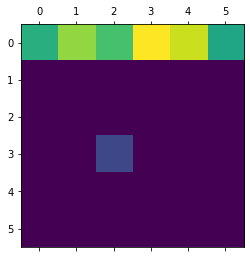

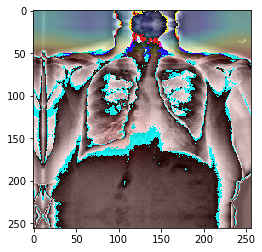

In [25]:
from keras import backend as k
import cv2
preds = model.predict(test_X)
argmax = np.argmax(preds[0])
output = model.output[:, argmax]
last_conv_layer = model.get_layer('conv2d_405')
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate(test_X)
for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()
img = test_X[0]
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
hif = 0.1
superimposed_img = heatmap * hif + np.uint8(255*img)
plt.imshow(superimposed_img.astype('uint8'))  